# First Type (Numerical only) - Kmeans

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from kmodes.util.dissim import matching_dissim
from sklearn.metrics import davies_bouldin_score, silhouette_score, silhouette_samples, calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance, SilhouetteVisualizer
from yellowbrick.utils import KneeLocator, get_param_names
from sklearn.manifold import TSNE

# Load dataset
data = pd.read_csv(r'C:\Users\63917\Desktop\Accenture\Initial\Clustering\energy_dataset.csv')

In [3]:
# Inspect dataset
data

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89


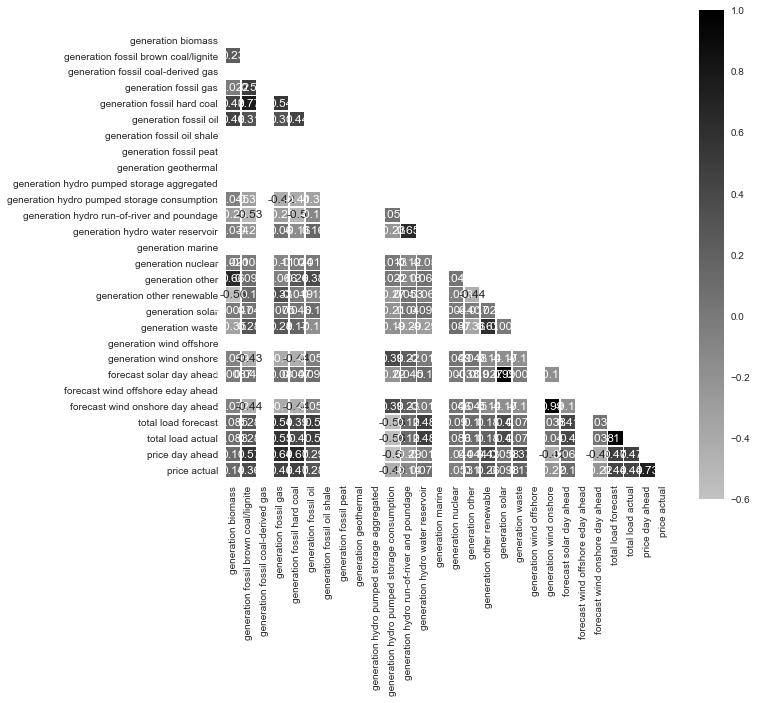

In [4]:
# Check correlation between variables
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.light_palette('black', as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

In [5]:
# Check for missing values and data type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [6]:
# Check summary statistics
data.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,...,35045.000000,35046.0,35046.000000,35064.000000,0.0,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,...,269.452133,0.0,5464.479769,1439.066735,NaN,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,...,50.195536,0.0,3213.691587,1677.703355,NaN,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,...,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,...,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,...,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,...,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,...,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


In [7]:
# Remove unecessary cols
data.drop(['time','generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead'], axis = 1, inplace = True)

In [8]:
# Check remaining cols
data.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind onshore day ahead', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual'],
      dtype='object')

In [9]:
# Null values are low. Can be set to zero
data.fillna(0, inplace = True)

In [10]:
# Scale the data first
scaler =StandardScaler()
data_scaled = scaler.fit_transform(data)

### COMBINATION 1: All columns

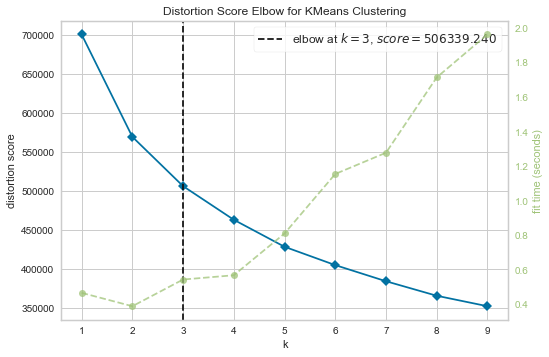

In [11]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(data_scaled)    
visualizer.poof()

In [12]:
# Performance scores
sse_list = []
sc_list = []
dbs_list = []
chs_list = []
k_list = range(2,11)

for k in k_list:
    km = KMeans(n_clusters=k, random_state=0)
    km = km.fit(data_scaled)
    
    sse_list.append(km.inertia_)
    sc_list.append(silhouette_score(data_scaled, km.labels_))
    dbs_list.append(davies_bouldin_score(data_scaled, km.labels_))
    chs_list.append(calinski_harabasz_score(data_scaled, km.labels_))

Text(0.5, 0, 'Number of Clusters')

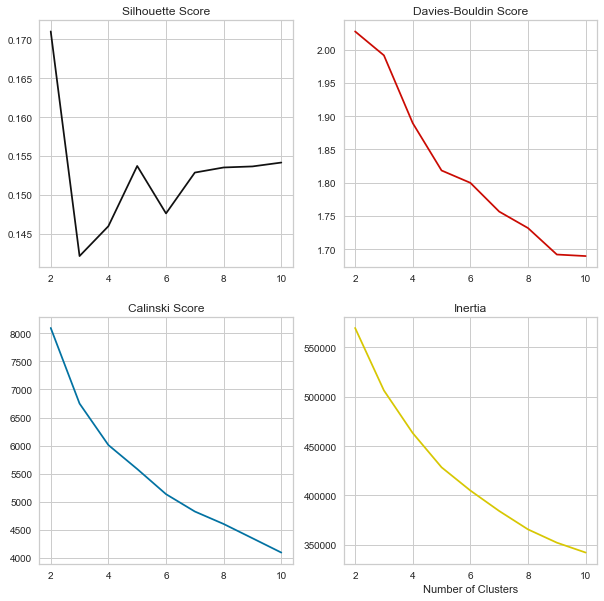

In [13]:
# Performance metrics
fig, axs = plt.subplots(2, 2, figsize = [10,10])

plt.title('KMeans')
axs[0, 0].plot(k_list, sc_list, 'k')
axs[0, 0].set_title('Silhouette Score')
axs[0, 1].plot(k_list, dbs_list, 'r')
axs[0, 1].set_title('Davies-Bouldin Score')
axs[1, 0].plot(k_list, chs_list, 'b')
axs[1, 0].set_title('Calinski Score')
axs[1, 1].plot(k_list, sse_list, 'y')
axs[1, 1].set_title('Inertia')
plt.xlabel('Number of Clusters')

We can estimate that the best is k = 2. Even though the elbow is at k = 3, the rest of the metrics are still high at k = 2.


In [15]:
n_clusters=2

kmeans = KMeans(n_clusters = n_clusters,random_state=12345)
cluster_labels = kmeans.fit_predict(data_scaled)
preds = kmeans.labels_

In [25]:
# Cluster visualization
tsne = TSNE(learning_rate=100)
transformed = tsne.fit_transform(data_scaled)
xs = transformed[:,0]
ys = transformed[:,1]

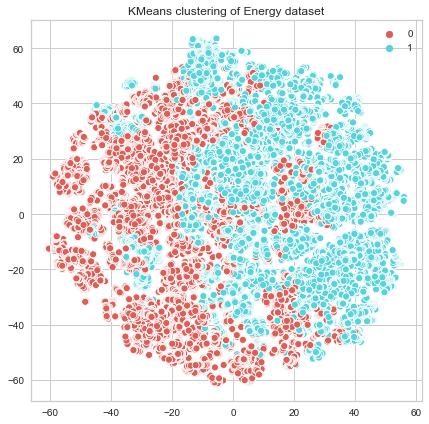

In [29]:
plt.figure(figsize=(7,7))

sns.scatterplot(
    xs, ys, hue = cluster_labels,
    palette=sns.color_palette("hls", n_clusters),
    data=data,
    legend="full",
)
plt.title('KMeans clustering of Energy dataset')

plt.savefig('naga_the_researcher_kmeans.jpg', bbox_inches = 'tight')

In [31]:
# Cluster interpretation
data_labeled = data.copy()
data_labeled['Cluster'] = preds
data_labeled.groupby('Cluster').agg(
    {
        'total load forecast': 'mean',
        'total load actual': 'mean',
        'price day ahead': 'mean',
        'price actual': 'mean'    
    }
).reset_index()

,Cluster,total load forecast,total load actual,price day ahead,price actual
0,0,26007.523349,25992.610805,39.158099,49.876646
1,1,30931.423988,30911.717609,58.667669,64.454562


.

.

# Second Type (Categorical only) - Kmodes

In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from kmodes.util.dissim import matching_dissim
from sklearn.metrics import davies_bouldin_score, silhouette_score, silhouette_samples, calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance, SilhouetteVisualizer
from yellowbrick.utils import KneeLocator, get_param_names
from sklearn.manifold import TSNE


data = pd.read_csv(r'C:\Users\63917\Desktop\Accenture\Initial\Clustering\mushrooms.csv')

In [57]:
data

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [59]:
data.describe(exclude = 'number')

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [60]:
data.shape

(8124, 23)

### COMBINATION 1: Hide class column (expect 2 clusters)

In [61]:
data1 = data.drop(['class'], axis = 1)

In [62]:
data1 = pd.get_dummies(data1)

In [63]:
data1.shape

(8124, 117)

### KMeans

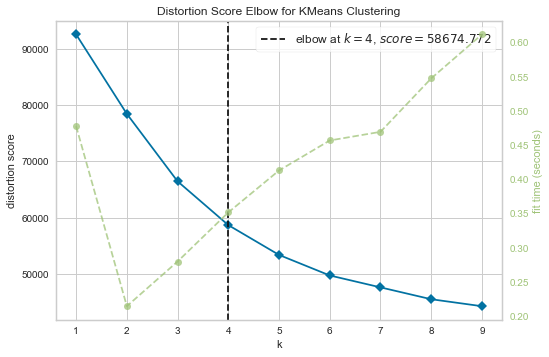

In [50]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(data1)    
visualizer.poof()

In [64]:
# Performance scores
sse_list = []
sc_list = []
dbs_list = []
chs_list = []
k_list = range(2,11)

for k in k_list:
    km = KMeans(n_clusters=k, random_state=0)
    km = km.fit(data1)
    
    sse_list.append(km.inertia_)
    sc_list.append(silhouette_score(data1, km.labels_))
    dbs_list.append(davies_bouldin_score(data1, km.labels_))
    chs_list.append(calinski_harabasz_score(data1, km.labels_))

Text(0.5, 0, 'Number of Clusters')

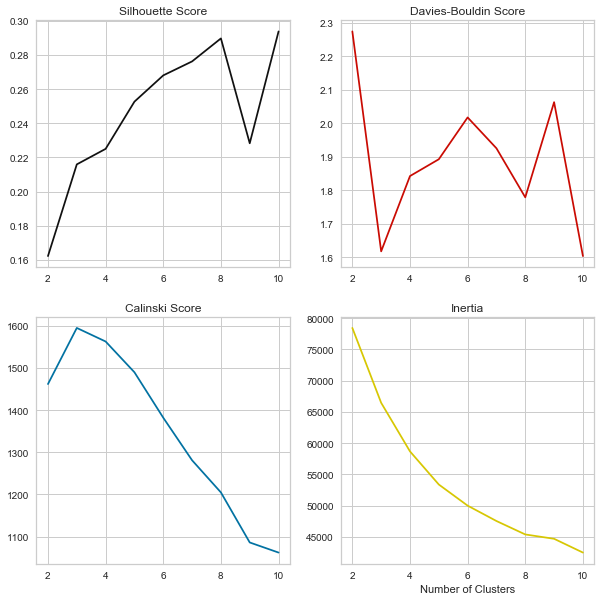

In [52]:
# Performance metrics
fig, axs = plt.subplots(2, 2, figsize = [10,10])

plt.title('KMeans')
axs[0, 0].plot(k_list, sc_list, 'k')
axs[0, 0].set_title('Silhouette Score')
axs[0, 1].plot(k_list, dbs_list, 'r')
axs[0, 1].set_title('Davies-Bouldin Score')
axs[1, 0].plot(k_list, chs_list, 'b')
axs[1, 0].set_title('Calinski Score')
axs[1, 1].plot(k_list, sse_list, 'y')
axs[1, 1].set_title('Inertia')
plt.xlabel('Number of Clusters')

COMPARING EACH RESULTS IS ACTUALLY HARD. But we can estimate that the best k = 4

In [14]:
n_clusters=4

kmeans = KMeans(n_clusters = n_clusters,random_state=12345)
cluster_labels = kmeans.fit_predict(data1)
preds = kmeans.labels_

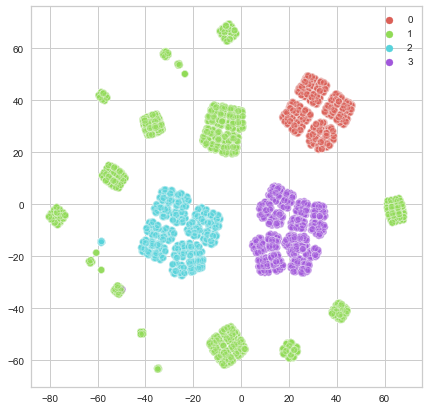

In [54]:
# Cluster visualization
tsne = TSNE(learning_rate=150)
transformed = tsne.fit_transform(data1)
xs = transformed[:,0]
ys = transformed[:,1]
plt.figure(figsize=(7,7))

sns.scatterplot(
    xs, ys, hue = cluster_labels,
    palette=sns.color_palette("hls", n_clusters),
    data=data1,
    legend="full",
    alpha=0.3
)

In [55]:
xs.shape

(8124,)

In [56]:
# Cluster interpretation
data_labeled = data.copy()
data_labeled['Cluster'] = preds
data_labeled.groupby('Cluster').agg(
    {
        'cap-shape': lambda x: x.value_counts().index[0],
        'odor': lambda x: x.value_counts().index[0],
        'stalk-shape': lambda x: x.value_counts().index[0],
        'population': lambda x: x.value_counts().index[0],
        'habitat': lambda x: x.value_counts().index[0]
    }
).reset_index()

,Cluster,cap-shape,odor,stalk-shape,population,habitat
0,0,f,f,e,y,d
1,1,x,n,e,s,g
2,2,k,f,t,v,d
3,3,f,n,t,v,d


### KModes

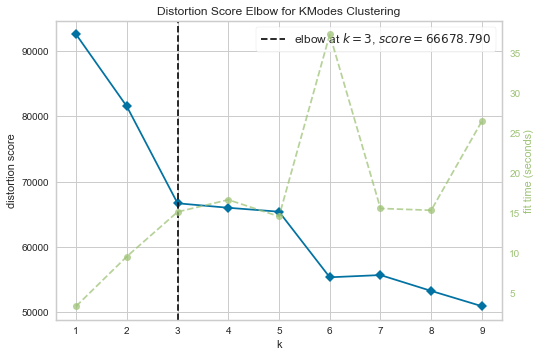

In [21]:
model = KModes()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(data1)    
visualizer.poof()

In [23]:
# Performance metric scores
sc_list = []
dbs_list = []
chs_list = []
k_list = range(2,11)
for k in k_list:
    km = KModes(n_clusters=k, random_state=0)
    km = km.fit(data1)
    sc_list.append(silhouette_score(data1, km.labels_))
    dbs_list.append(davies_bouldin_score(data1, km.labels_))
    chs_list.append(calinski_harabasz_score(data1, km.labels_))

Text(0.5, 0, 'Number of Clusters')

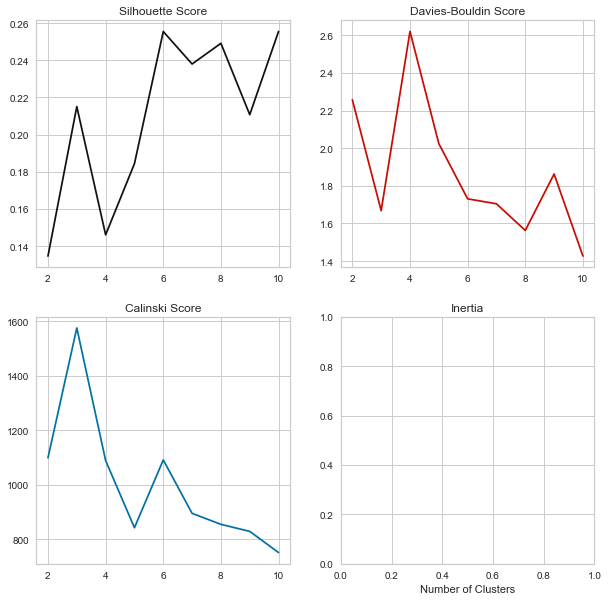

In [61]:
# Performance metrics
fig, axs = plt.subplots(2, 2, figsize = [10,10])

plt.title('KMeans')
axs[0, 0].plot(k_list, sc_list, 'k')
axs[0, 0].set_title('Silhouette Score')
axs[0, 1].plot(k_list, dbs_list, 'r')
axs[0, 1].set_title('Davies-Bouldin Score')
axs[1, 0].plot(k_list, chs_list, 'b')
axs[1, 0].set_title('Calinski Score')
# axs[1, 1].plot(k_list, sse_list, 'y')
axs[1, 1].set_title('Inertia')
plt.xlabel('Number of Clusters')

COMPARING EACH RESULTS IS ACTUALLY HARD. But we can estimate that the best k = 3

In [68]:
# Train based on best k
n_clusters=3

kmodes = KModes(n_clusters = n_clusters,random_state=12345)
cluster_labels = kmodes.fit_predict(data1)
preds = kmodes.labels_

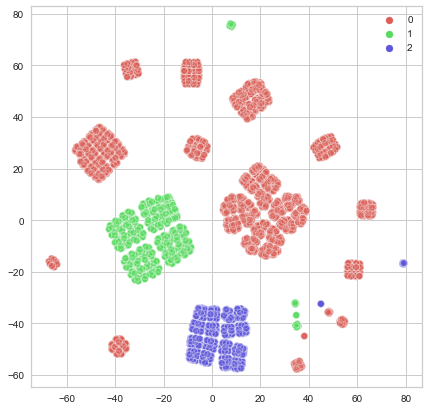

In [69]:
# Cluster visualization
tsne = TSNE(learning_rate=150)
transformed = tsne.fit_transform(data1)
xs = transformed[:,0]
ys = transformed[:,1]
plt.figure(figsize=(7,7))

sns.scatterplot(
    xs, ys, hue = cluster_labels,
    palette=sns.color_palette("hls", n_clusters),
    data=data1,
    legend="full",
    alpha=0.3
)

In [70]:
# Cluster interpretation
data_labeled = data.copy()
data_labeled['Cluster'] = preds
data_labeled.groupby('Cluster').agg(
    {
        'cap-shape': lambda x: x.value_counts().index[0],
        'odor': lambda x: x.value_counts().index[0],
        'stalk-shape': lambda x: x.value_counts().index[0],
        'population': lambda x: x.value_counts().index[0],
        'habitat': lambda x: x.value_counts().index[0]
    }
).reset_index()

,Cluster,cap-shape,odor,stalk-shape,population,habitat
0,0,x,n,t,v,d
1,1,f,f,t,v,d
2,2,f,f,e,y,d


### COMBINATION 2: Use all columns and apply KModes

In [26]:
data2 = pd.get_dummies(data)

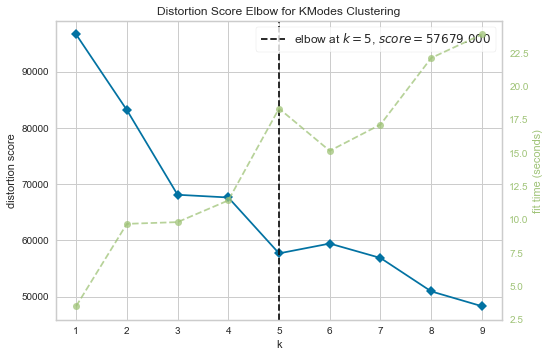

In [29]:
model = KModes()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(data2)    
visualizer.poof()

In [27]:
# Performance metric scores
sc_list = []
dbs_list = []
chs_list = []
k_list = range(2,11)
for k in k_list:
    km = KModes(n_clusters=k, random_state=0)
    km = km.fit(data2)
    sc_list.append(silhouette_score(data2, km.labels_))
    dbs_list.append(davies_bouldin_score(data2, km.labels_))
    chs_list.append(calinski_harabasz_score(data2, km.labels_))

Text(0.5, 0, 'Number of Clusters')

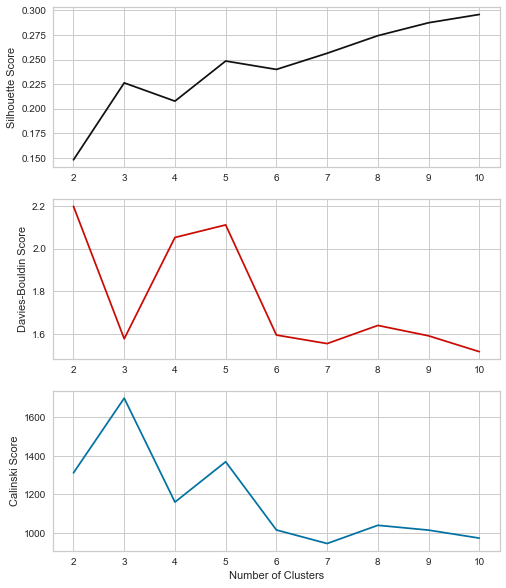

In [34]:
# Performance metrics
fig, axs = plt.subplots(3, figsize = [8,10])

axs[0].plot(k_list, sc_list, 'k')
axs[0].set_ylabel('Silhouette Score')
axs[1].plot(k_list, dbs_list, 'r')
axs[1].set_ylabel('Davies-Bouldin Score')
axs[2].plot(k_list, chs_list, 'b')
axs[2].set_ylabel('Calinski Score')
# axs[1, 1].plot(k_list, sse_list, 'y')
plt.xlabel('Number of Clusters')

COMPARING EACH RESULTS IS ACTUALLY HARD. But we can estimate that the best k = 5

In [35]:
# Train based on best k
n_clusters=5

kmodes = KModes(n_clusters = n_clusters,random_state=12345)
cluster_labels = kmodes.fit_predict(data2)
preds = kmodes.labels_

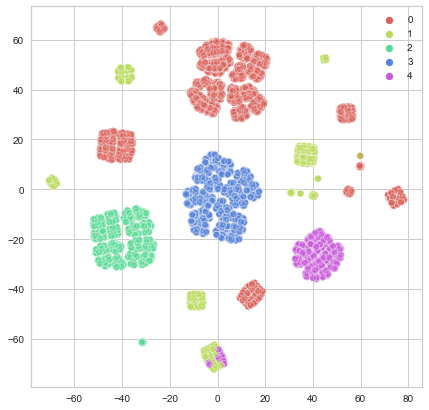

In [36]:
# Cluster visualization
tsne = TSNE(learning_rate=150)
transformed = tsne.fit_transform(data2)
xs = transformed[:,0]
ys = transformed[:,1]
plt.figure(figsize=(7,7))

sns.scatterplot(
    xs, ys, hue = cluster_labels,
    palette=sns.color_palette("hls", n_clusters),
    data=data2,
    legend="full",
    alpha=0.3
)

In [37]:
# Cluster interpretation
data_labeled = data.copy()
data_labeled['Cluster'] = preds
data_labeled.groupby('Cluster').agg(
    {
        'cap-shape': lambda x: x.value_counts().index[0],
        'odor': lambda x: x.value_counts().index[0],
        'stalk-shape': lambda x: x.value_counts().index[0],
        'population': lambda x: x.value_counts().index[0],
        'habitat': lambda x: x.value_counts().index[0]
    }
).reset_index()

,Cluster,cap-shape,odor,stalk-shape,population,habitat
0,0,x,n,t,v,d
1,1,x,n,e,v,g
2,2,f,f,e,y,d
3,3,f,y,t,v,p
4,4,x,n,t,s,g


.

.

# 3rd Type (Mixed) - Kprototypes

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import davies_bouldin_score, silhouette_score, silhouette_samples, calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance, SilhouetteVisualizer
from yellowbrick.utils import KneeLocator, get_param_names
from sklearn.manifold import TSNE


data = pd.read_csv(r'C:\Users\63917\Desktop\Accenture\Initial\Clustering\Sales Records.csv')

In [2]:
data

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
0,Sub-Saharan Africa,Chad,Office Supplies,Online,L,1/27/2011,292494523,2/12/2011,4484,651.21,524.96,2920025.64,2353920.64,566105.00
1,Europe,Latvia,Beverages,Online,C,12/28/2015,361825549,1/23/2016,1075,47.45,31.79,51008.75,34174.25,16834.50
2,Middle East and North Africa,Pakistan,Vegetables,Offline,C,1/13/2011,141515767,2/1/2011,6515,154.06,90.93,1003700.90,592408.95,411291.95
3,Sub-Saharan Africa,Democratic Republic of the Congo,Household,Online,C,9/11/2012,500364005,10/6/2012,7683,668.27,502.54,5134318.41,3861014.82,1273303.59
4,Europe,Czech Republic,Beverages,Online,C,10/27/2015,127481591,12/5/2015,3491,47.45,31.79,165647.95,110978.89,54669.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Asia,Laos,Beverages,Online,H,7/15/2014,199342048,7/31/2014,8597,47.45,31.79,407927.65,273298.63,134629.02
9996,Europe,Liechtenstein,Cosmetics,Online,C,10/27/2012,763044106,11/1/2012,562,437.20,263.33,245706.40,147991.46,97714.94
9997,Sub-Saharan Africa,Democratic Republic of the Congo,Vegetables,Offline,M,2/14/2013,848579967,3/20/2013,2524,154.06,90.93,388847.44,229507.32,159340.12
9998,Sub-Saharan Africa,South Africa,Meat,Online,L,2/19/2017,298185956,2/22/2017,8706,421.89,364.69,3672974.34,3174991.14,497983.20


In [5]:
# Get the position of categorical columns
catcols = [data.columns.get_loc(col) for col in list(data.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(data.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['Region', 'Country', 'Item Type', 'Sales Channel', 'Order Priority', 'Order Date', 'Ship Date']
Categorical columns position  : [0, 1, 2, 3, 4, 5, 7]


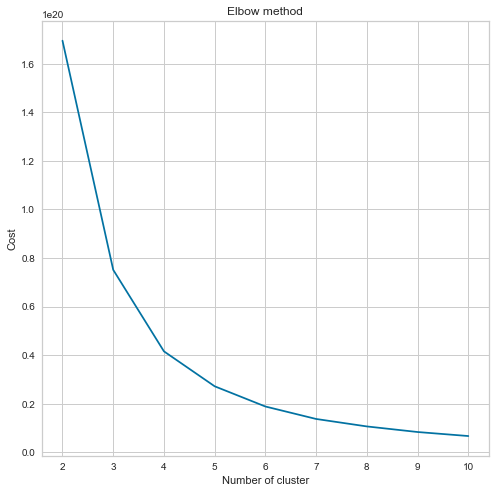

In [9]:
# Performance metric
data_matrix = data.to_numpy()
cost_list = []
k_list = range(2,11)
for k in k_list:
    kprototype = KPrototypes(n_clusters = k, init = 'Huang', random_state = 0)
    kprototype.fit_predict(data_matrix, categorical = catcols)
    cost_list.append(kprototype.cost_)
#         print('Cluster initiation: {}'.format(cluster))
#     except:
#         break

plt.figure(figsize = [8,8])

plt.plot(k_list, cost_list)
plt.xlabel('Number of cluster')
plt.ylabel('Cost')
plt.title('Elbow method')

plt.show()

COMPARING EACH RESULTS IS ACTUALLY HARD. But we can estimate that the best k = 4

In [11]:
# Train based on best k
n_clusters=4

kprototype = KPrototypes(n_clusters = n_clusters, init = 'Huang', random_state = 0)
cluster_labels = kprototype.fit_predict(data_matrix, categorical = catcols)
preds = kprototype.labels_

In [14]:
# Cluster interpretation
data_labeled = data.copy()
data_labeled['Cluster'] = preds
data_labeled.groupby('Cluster').agg(
    {
        'Region' : lambda x: x.value_counts().index[0],
        'Country': lambda x: x.value_counts().index[0],
        'Item Type': lambda x: x.value_counts().index[0],
        'Sales Channel': lambda x: x.value_counts().index[0],
        'Units Sold': 'mean',
        'Unit Price': 'mean',
        'Total Revenue': 'mean',
        'Total Cost': 'mean',    }
).reset_index()

,Cluster,Region,Country,Item Type,Sales Channel,Units Sold,Unit Price,Total Revenue,Total Cost
0,0,Sub-Saharan Africa,Cambodia,Personal Care,Online,5095.789044,261.458788,1.329533e+06,936172.894320
1,1,Europe,Rwanda,Office Supplies,Offline,4909.641471,274.265085,1.309888e+06,920265.536900
2,2,Europe,Kosovo,Cereal,Online,5015.379366,262.702636,1.318028e+06,926333.617071
3,3,Europe,Guatemala,Cosmetics,Online,4987.020482,274.349703,1.375778e+06,970111.850960
